In [1]:
import pandas as pd
import cv2
from pylab import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib

#%matplotlib inline

In [2]:
df_train = pd.read_pickle("../data/VOC2007/VOC-training.pkl")
df_test = pd.read_pickle("../data/VOC2007/VOC-testing.pkl")

In [3]:
image_paths_train = list(df_train["image.paths"])
image_paths_test = list(df_test["image.paths"])

## Sample images

More importantly, check if images are in correct directories. 

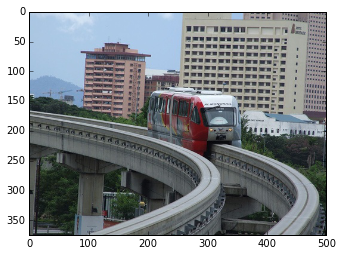

In [4]:
img = cv2.imread(image_paths_train[0])
#imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

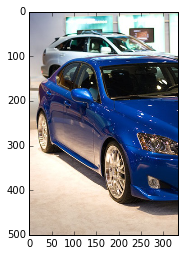

In [5]:
img = cv2.imread(image_paths_test[0])
#imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Single Layer feature learning

In [6]:
from util.skicaffe import SkiCaffe

In [7]:
caffe_root = '/usr/local/src/caffe/caffe-master/'
model_prototxt = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_trained = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
DLmodel = SkiCaffe(caffe_root = caffe_root,model_prototxt_path = model_prototxt, model_trained_path = model_trained, layer_name = 'fc8')
DLmodel.fit()
print 'Number of layers:', len(DLmodel.layer_sizes)
DLmodel.layer_sizes

caffe imported successfully
Number of layers: 15


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [8]:
X_train = image_paths_train
y_train = MultiLabelBinarizer().fit_transform(df_train.classes)
print "num examples from X", len(X_train)
print "num examples and labels from y", y_train.shape

num examples from X 5011
num examples and labels from y (5011, 20)


In [9]:
layers = [l[0] for l in DLmodel.layer_sizes]
layers.remove('data')

best_params = []
best_scores = []

for layer in layers:
    print 'working on layer', layer
    feature_pipe = Pipeline([('ANN', SkiCaffe(caffe_root = caffe_root,model_prototxt_path = model_prototxt, model_trained_path = model_trained, layer_name = layer))])
    feaures = feature_pipe.fit_transform(X_train)

    svc_pipe = Pipeline([('OVCsvc', OneVsRestClassifier(SVC(random_state = 1, kernel = 'linear')))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'OVCsvc__estimator__C': param_range}]
    gs = GridSearchCV(estimator = svc_pipe, param_grid = param_grid, scoring = 'average_precision', cv = 5, n_jobs=-1)
    gs.fit(feaures, array(y_train))
    best_params.append(gs.best_params_)
    best_scores.append(gs.best_score_)
    

caffe imported successfully
caffe imported successfully


In [11]:
results_df = pd.DataFrame({'layer.name': layers, 'best_scores': best_scores, 'best_params': best_params})

results_df.head()

,best_params,best_scores,layer.name
0,{u'OVCsvc__estimator__C': 0.0001},0.602760,fc6
1,{u'OVCsvc__estimator__C': 0.0001},0.666165,fc7


In [12]:
results_df.to_pickle("../results/VOC-SVM.pkl")